# Imports

In [1]:
import pandas as pd
import numpy as np
np.random.seed(2121)

import matplotlib.pyplot as plt

In [2]:
batpos = pd.read_csv('../data/batpos_eda.csv')

# Lookbacks

The nature of our dataset is that a player's performance will be across multiple lines in our dataset. We are interested in players who have a consecutive set of years in the database so we can look into their historical performance to make inferences.

A few approaches will be made to see how our dataset changes (in number of rows) for lookback windows of 2, 3, and 5 years.

## Calculate lookback loss

In [3]:
# sort df by player-year to ensure proper shifting
batpos = batpos.sort_values(['player_id','year_id'])

In [4]:
def lookback_counts(yr):
    '''returns the count of rows remaining in the df using a lookback
       value of yr where the yrs must be non-null and consecutive'''
    
    # create our working df
    _yrlookback =\
        pd.Series(
            pd.DataFrame(
                    [batpos.groupby('player_id')['year_id'].shift(i)
                     for i in range(1,yr+1)]).T.values.tolist(),
        name='_yr_lookback')
    
    df = batpos.join(_yrlookback)
    
     
    # remove rows where _yr_lookback array includes a nan
    # create mask to count nulls
    null_count = df['_yr_lookback']\
                    .map(lambda x: sum([1 if pd.isnull(i) else 0 for i in x]))

    # use mask to keep only rows with mask value 0
    df = df.loc[null_count==0]
    
     # remove rows where _yr_lookback years aren't consecutive
    consec = df.apply(lambda row:
                 [row.year_id - x for x in row['_yr_lookback']] 
                      == list(range(1,yr+1))
                    , axis = 1)

    # use mask to keep only rows with mask value 0
    df = df.loc[consec]
    
    return df.shape[0], df

## Lookback comparisions

The longer our lookback, the fewer players we can expect to have in our dataset. To qualify for a specific lookback window, the player must have that number of consecutive years +1 in the dataset.

In [5]:
lb2 = lookback_counts(2) # 2year
lb3 = lookback_counts(3) # 3
lb5 = lookback_counts(5) # 5
lb6 = lookback_counts(6) #6
lb10 = lookback_counts(10) #10 
rows = batpos.shape[0] #players we started with

print('Lookback Loss\n')

print(f'2 year lookback: {lb2[0]} rows\n'+\
      f'{lb2[0]/rows:.2f} of original\n'+\
      f'{lb2[1].name_common.unique().shape[0]} players total\n')

print(f'3 year lookback: {lb3[0]} rows\n'+\
      f'{lb3[0]/rows:.2f} of original\n'+\
      f'{lb3[1].name_common.unique().shape[0]} players total\n')

print(f'5 year lookback: {lb5[0]} rows\n'+\
      f'{lb5[0]/rows:.2f} of original\n'+\
      f'{lb5[1].name_common.unique().shape[0]} players total\n')

print(f'10 year lookback: {lb10[0]} rows\n'+\
      f'{lb10[0]/rows:.2f} of original\n'+\
      f'{lb10[1].name_common.unique().shape[0]} players total\n')


Lookback Loss

2 year lookback: 7268 rows
0.57 of original
1388 players total

3 year lookback: 5694 rows
0.45 of original
1159 players total

5 year lookback: 3460 rows
0.27 of original
776 players total

10 year lookback: 813 rows
0.06 of original
248 players total



## Lookback Feature Extraction

### Standard Lookback approach (3-year)

In [6]:
batpos_ex = batpos.copy()

In [7]:
# create lookbacks for everything except our player vars, and age
cols = ['waa_pg','g', 'team_gp',
       'pa_pg', 'inn_pg', 'runs_bat_pg', 'runs_br_pg', 'runs_dp_pg',
       'runs_defense_pg', 'runs_position_pg','opprpg',
       'percent_team_gp', 'pa_per_team_gp',
       'inn_per_team_gp', 'g_c_share', 'g_1b_share', 'g_2b_share',
       'g_3b_share', 'g_ss_share', 'g_cf_share', 'g_dh_share', 'g_cof_share']

for c in cols:
    for i in range(1,4):
        batpos_ex[c+'_'+str(i)+'yr'] =\
        pd.DataFrame(
                [batpos_ex.groupby('player_id')[c].shift(i)]).T
    
#     if c != 'waa_pg':
#         batpos_ex.drop(c, axis=1, inplace=True)

In [8]:
batpos_ex

,waa_pg,player_id,year_id,name_common,age,g,team_gp,pa_pg,inn_pg,runs_bat_pg,...,g_ss_share_3yr,g_cf_share_1yr,g_cf_share_2yr,g_cf_share_3yr,g_dh_share_1yr,g_dh_share_2yr,g_dh_share_3yr,g_cof_share_1yr,g_cof_share_2yr,g_cof_share_3yr
0,0.038526,aaronha01,1962,Henry Aaron,28.0,156,162.0,4.275641,8.594231,0.364038,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,0.039876,aaronha01,1963,Henry Aaron,29.0,161,163.0,4.434783,8.981366,0.381925,...,NaN,0.535484,NaN,NaN,0.000000,NaN,NaN,0.458065,NaN,NaN
2,0.030621,aaronha01,1964,Henry Aaron,30.0,145,162.0,4.372414,8.505517,0.262552,...,NaN,0.000000,0.535484,NaN,0.000000,0.000000,NaN,1.000000,0.458065,NaN
3,0.036000,aaronha01,1965,Henry Aaron,31.0,150,162.0,4.260000,8.728667,0.287333,...,0.0,0.000000,0.000000,0.535484,0.000000,0.000000,0.000000,0.926667,1.000000,0.458065
4,0.034367,aaronha01,1966,Henry Aaron,32.0,158,163.0,4.354430,8.596835,0.225886,...,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.926667,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12721,-0.009389,zuninmi01,2014,Mike Zunino,23.0,131,162.0,3.633588,8.625954,-0.072595,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
12722,-0.018304,zuninmi01,2015,Mike Zunino,24.0,112,162.0,3.446429,8.211607,-0.224018,...,NaN,0.000000,NaN,NaN,0.007634,NaN,NaN,0.000000,NaN,NaN
12723,0.015403,zuninmi01,2017,Mike Zunino,26.0,124,162.0,3.508065,8.161290,0.100887,...,NaN,0.000000,0.000000,NaN,0.000000,0.007634,NaN,0.000000,0.000000,NaN
12724,0.004336,zuninmi01,2018,Mike Zunino,27.0,113,162.0,3.584071,8.236283,-0.076903,...,0.0,0.000000,0.000000,0.000000,0.016393,0.000000,0.007634,0.000000,0.000000,0.000000


In [9]:
# using the df from our 3-year lookback, merge with batpos to mask it

batpos_ex = pd.merge(lb3[1][['player_id','year_id']], batpos_ex,
                 on = ['player_id', 'year_id'])

# reorder
batpos_ex = batpos_ex.iloc[:,[2]]\
                    .join(batpos_ex.iloc[:,0:2])\
                    .join(batpos_ex.iloc[:,3:])

### Time-Series* Approach

In [10]:
batpos_time = batpos.copy()

In [11]:
batpos_time.set_index(['player_id','year_id'],
                      inplace=True)

In [12]:
# create a df of a single player only
aaron = batpos_time[batpos_time.name_common == 'Henry Aaron']

# reset index to just 'year id'
aaron.reset_index(inplace=True)
aaron.set_index('year_id',inplace=True)

# remove string vals
aaron = aaron.drop(['player_id','name_common'], axis=1)

In [13]:
# date format index
aaron.index = pd.to_datetime(aaron.index, format = '%Y' )

In [14]:
# create shift fir waa_pg
for i in range(1,4):
    aaron['waa_pg_lag_'+str(i)] = aaron.waa_pg.shift(i)

In [15]:
# # drop rows that don't have appropriate lookback data
# aaron.dropna(inplace=True)

In [16]:
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [17]:
decomp = seasonal_decompose(aaron['waa_pg'],)

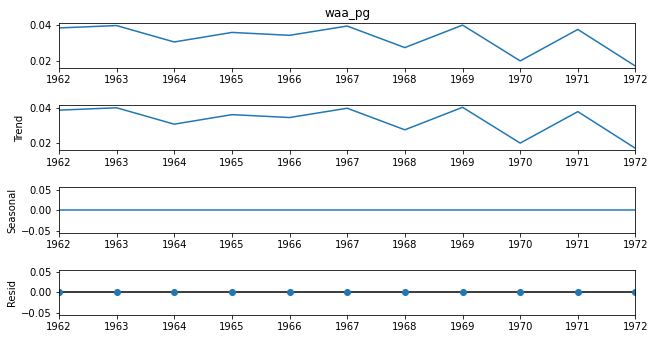

In [18]:
decomp.plot()
fig = plt.gcf()
fig.set_size_inches(10,5);

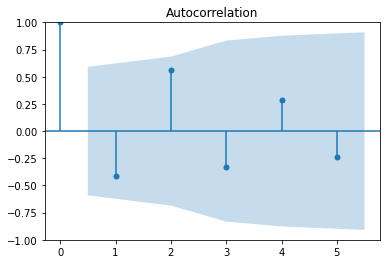

In [19]:
plot_acf(aaron['waa_pg'], lags =5);

C:\Users\Larry\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


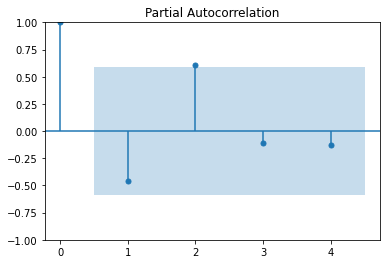

In [20]:
plot_pacf(aaron['waa_pg'], lags =4);

### NN approach (5-year)

In [24]:
batpos_nn = batpos.copy()

In [25]:
# create lookbacks for everything except our player vars, and age
cols = ['waa_pg','g', 'team_gp',
       'pa_pg', 'inn_pg', 'runs_bat_pg', 'runs_br_pg', 'runs_dp_pg',
       'runs_defense_pg', 'runs_position_pg',  'opprpg',
        'percent_team_gp', 'pa_per_team_gp',
       'inn_per_team_gp', 'g_c_share', 'g_1b_share', 'g_2b_share',
       'g_3b_share', 'g_ss_share', 'g_cf_share', 'g_dh_share', 'g_cof_share']

for c in cols:
    for i in range(1,6):
        batpos_nn[c+'_'+str(i)+'yr'] =\
        pd.DataFrame(
                [batpos_nn.groupby('player_id')[c].shift(i)]).T
    
    if c != 'waa_pg':
        batpos_nn.drop(c, axis=1, inplace=True)

In [26]:
# using the df from our 5-year lookback, merge with batpos to mask it

batpos_nn = pd.merge(lb3[1][['player_id','year_id']], batpos_nn,
                 on = ['player_id', 'year_id'])

# reorder
batpos_nn = batpos_nn.iloc[:,[2]]\
                    .join(batpos_nn.iloc[:,0:2])\
                    .join(batpos_nn.iloc[:,3:])

In [27]:
batpos_nn.dropna(inplace=True)

In [28]:
batpos_nn

,waa_pg,player_id,year_id,name_common,age,waa_pg_1yr,waa_pg_2yr,waa_pg_3yr,waa_pg_4yr,waa_pg_5yr,...,g_dh_share_1yr,g_dh_share_2yr,g_dh_share_3yr,g_dh_share_4yr,g_dh_share_5yr,g_cof_share_1yr,g_cof_share_2yr,g_cof_share_3yr,g_cof_share_4yr,g_cof_share_5yr
2,0.039613,aaronha01,1967,Henry Aaron,33.0,0.034367,0.036000,0.030621,0.039876,0.038526,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.957576,1.000000,0.926667,1.000000,0.458065
3,0.027437,aaronha01,1968,Henry Aaron,34.0,0.039613,0.034367,0.036000,0.030621,0.039876,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.922078,0.957576,1.000000,0.926667,1.000000
4,0.040136,aaronha01,1969,Henry Aaron,35.0,0.027437,0.039613,0.034367,0.036000,0.030621,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.915152,0.922078,0.957576,1.000000,0.926667
5,0.019933,aaronha01,1970,Henry Aaron,36.0,0.040136,0.027437,0.039613,0.034367,0.036000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.972973,0.915152,0.922078,0.957576,1.000000
6,0.037698,aaronha01,1971,Henry Aaron,37.0,0.019933,0.040136,0.027437,0.039613,0.034367,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.919118,0.972973,0.915152,0.922078,0.957576
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5689,0.015137,zobribe01,2014,Ben Zobrist,33.0,0.018471,0.021274,0.033654,0.014901,0.042697,...,0.010417,0.022222,0.017442,0.000000,0.005435,0.223958,0.394444,0.220930,0.550265,0.369565
5690,0.004762,zobribe01,2015,Ben Zobrist,34.0,0.015137,0.018471,0.021274,0.033654,0.014901,...,0.043956,0.010417,0.022222,0.017442,0.000000,0.313187,0.223958,0.394444,0.220930,0.550265
5691,0.009932,zobribe01,2016,Ben Zobrist,35.0,0.004762,0.015137,0.018471,0.021274,0.033654,...,0.046512,0.043956,0.010417,0.022222,0.017442,0.387597,0.313187,0.223958,0.394444,0.220930
5692,-0.011406,zobribe01,2017,Ben Zobrist,36.0,0.009932,0.004762,0.015137,0.018471,0.021274,...,0.000000,0.046512,0.043956,0.010417,0.022222,0.296512,0.387597,0.313187,0.223958,0.394444


# Exports

In [29]:
batpos_ex.to_csv('../data/batpos_feature_extracted.csv',index=False)
batpos_nn.to_csv('../data/batpos_nn.csv', index=False)